## First, get the data into a useful format

In [0]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Read in datafiles
gfs = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Project_4/GFSDaily/GFS_Daily_PredictVars_2010thru2019.csv', index_col = 'Date', usecols = ['Date', 'TMAX', 'TMIN', 'WMAX', 'RTOT'], parse_dates = True)
# gfsfs = pd.read_csv('./raw_data/GFS_Sfc_42hrFcst_2010thru2019.csv', skiprows=1, index_col = 'Date', parse_dates = True)
hourly = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Project_4/KCMI_hourly_tidy.csv', index_col = 'Timestamp', parse_dates = True)
hourly.index = hourly.index + pd.DateOffset(hours=12)  # Align times

obs = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Project_4/KCMI_daily_tidy.csv', index_col = 'Date', parse_dates = True)
obs.index = obs.index + pd.DateOffset(hours=12)  # Align times

sfc = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Project_4/GFSSfc/GFS_Sfc_06Zto06ZAvgMinMax_AdditionalVars_2010thru2019.csv',  index_col = 'Unnamed: 0', parse_dates = True)
sfc.index = sfc.index + pd.DateOffset(days=1)  # Align times
prof = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Project_4/GFSProfile/GFS_Prof_06Zto06ZAvgMinMax_2010thru2019.csv',  index_col = 'Unnamed: 0', parse_dates = True)
prof.index = prof.index + pd.DateOffset(days=1)  # Align times

In [4]:
# There is some missing data from the GFS forecasts!
print(gfs.shape)
print(hourly.shape)
print(obs.shape)
print(sfc.shape)
print(prof.shape)

(3614, 4)
(3652, 7)
(3652, 4)
(3652, 15)
(3652, 60)


In [0]:
# Merge and drop all days with missing values 
features = pd.merge(obs.reset_index().dropna(), gfs.reset_index(), on = 'Date', how = 'inner')
features = pd.merge(features, hourly.reset_index(), left_on = 'Date', right_on = 'Timestamp', how = 'inner').drop(columns = 'Timestamp')
features = pd.merge(features, prof.reset_index(), left_on = 'Date', right_on = 'index', how = 'inner').drop(columns = 'index')
features = pd.merge(features, sfc.reset_index(), left_on = 'Date', right_on = 'index', how = 'inner').drop(columns = 'index')
features.dropna(inplace = True)  # There are some NaNs in the observations

In [6]:
features.describe()

,Max Hourly Temp (C),Min Hourly Temp (C),Max Wind Speed (m/s),Daily Precip (mm),TMAX,TMIN,WMAX,RTOT,tmpc,dwpc,mslp,wdir,wspd,skct,pr1h,Avg 250hPa DWPDEP(C),Min 250hPa DWPDEP(C),Max 250hPa DWPDEP(C),Avg 500hPa DWPDEP(C),Min 500hPa DWPDEP(C),Max 500hPa DWPDEP(C),Avg 700hPa DWPDEP(C),Min 700hPa DWPDEP(C),Max 700hPa DWPDEP(C),Avg 850hPa DWPDEP(C),Min 850hPa DWPDEP(C),Max 850hPa DWPDEP(C),Avg 925hPa DWPDEP(C),Min 925hPa DWPDEP(C),Max 925hPa DWPDEP(C),Avg 250hPa HGT(m),Min 250hPa HGT(m),Max 250hPa HGT(m),Avg 500hPa HGT(m),Min 500hPa HGT(m),Max 500hPa HGT(m),Avg 700hPa HGT(m),Min 700hPa HGT(m),Max 700hPa HGT(m),Avg 850hPa HGT(m),...,Max 500hPa TMPC,Avg 700hPa TMPC,Min 700hPa TMPC,Max 700hPa TMPC,Avg 850hPa TMPC,Min 850hPa TMPC,Max 850hPa TMPC,Avg 925hPa TMPC,Min 925hPa TMPC,Max 925hPa TMPC,Avg 250hPa WSPD(m/s),Min 250hPa WSPD(m/s),Max 250hPa WSPD(m/s),Avg 500hPa WSPD(m/s),Min 500hPa WSPD(m/s),Max 500hPa WSPD(m/s),Avg 700hPa WSPD(m/s),Min 700hPa WSPD(m/s),Max 700hPa WSPD(m/s),Avg 850hPa WSPD(m/s),Min 850hPa WSPD(m/s),Max 850hPa WSPD(m/s),Avg 925hPa WSPD(m/s),Min 925hPa WSPD(m/s),Max 925hPa WSPD(m/s),Avg DWPDEP(C),Min DWPDEP(C),Max DWPDEP(C),Avg LCLD(%),Min LCLD(%),Max LCLD(%),Avg MCLD(%),Min MCLD(%),Max MCLD(%),Avg HCLD(%),Min HCLD(%),Max HCLD(%),Avg PRES(hPa),Min PRES(hPa),Max PRES(hPa)
count,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,...,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000
mean,17.588466,6.551807,7.599818,2.039245,16.145107,7.199022,5.772318,3.315404,13.900928,6.845879,1017.487222,189.203968,4.998211,2.045122,0.071633,10.004415,6.064685,15.245521,13.468241,5.812949,23.224795,13.614435,5.744032,23.153565,9.099917,3.775235,15.967025,6.057081,3.050506,9.770494,10577.691234,10531.687687,10622.316166,5692.514221,5660.761297,5722.228554,3070.320592,3048.137029,3091.464382,1490.822512,...,-13.639533,0.325688,-1.622408,2.230619,7.253172,5.040688,9.605063,9.787866,7.303654,12.367429,61.092620,45.443314,77.432936,37.444128,26.740017,48.845248,25.569370,17.404384,33.885136,19.633493,12.128032,27.904516,18.583950,11.235938,27.087459,4.105653,1.609855,7.843748,20.846530,3.764160,46.387806,17.345102,1.130919,47.113278,36.469267,9.016094,69.911483,989.381213,986.438904,992.188765
std,11.899096,10.782862,2.932123,5.950638,11.201407,9.998378,2.349089,7.027440,11.958992,10.984311,7.014852,77.541998,2.359304,2.483259,0.321345,4.887187,3.830370,6.382814,6.903622,5.791070,9.183848,7.865052,6.578967,10.886116,6.491561,4.836805,9.369409,3.657594,2.953091,5.081714,274.578185,291.048721,259.200111,158.024749,172.892392,145.540414,93.140806,101.826084,85.890435,56.139228,...,6.030674,7.700150,8.446593,7.114768,9.304562,10.042108,8.728792,10.683645,11.288830,10.175028,29.429448,26.855082,33.189062,19.310846,16.694577,23.928116,12.122080,10.679616,14.806537,9.663558,8.166779,12.780029,8.550189,7.515700,10.910455,2.466819,1.627014,4.004422,27.164652,15.167326,42.981042,21.571487,7.485913,42.569690,30.263713,21.730328,37.603787,6.113929,6.585035,6.059707
min,-21.111111,-26.666667,2.235200,0.000000,-18.760000,-25.060000,1.431782,0.000000,-23.366667,-28.575000,988.527273,0.000000,0.125000,0.000000,-0

In [0]:
# Add year, month, day as integers 
features['year'] = features['Date'].dt.year
features['month'] = features['Date'].dt.month
features['day'] = features['Date'].dt.day

In [0]:
# The data we will be using to predict the labels
new_features = features.drop(columns = ['Date', 'Max Hourly Temp (C)', 'Min Hourly Temp (C)', 'Max Wind Speed (m/s)', 'Daily Precip (mm)'], axis = 1)

# Save feature list for later
feature_list = list(new_features.columns)

In [0]:
#feature_list

## Now run the model!

### Maximum Temperature

In [0]:
# Split the data into training and testing sets
train_features_tmax = np.array(new_features.query('year < 2019'))
test_features_tmax  = np.array(new_features.query('year == 2019'))
train_labels_tmax  = np.array(features.query('year < 2019')['Max Hourly Temp (C)'])
test_labels_tmax  = np.array(features.query('year == 2019')['Max Hourly Temp (C)'])

In [0]:
# Check if any NaNs exist
#new_features.query('year < 2019').isna().sum()

In [10]:
# Check if any NaNs exist
features.query('year == 2019')['Max Hourly Temp (C)'].isna().sum()

0

In [11]:
# Let's check how well the GFS forecast does. This will be our 'base prediction'
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels_tmax , new_features.query('year == 2019')['TMAX'].values)), 2), 'degrees C.')

Root Mean Square Error: 4.51 degrees C.


In [12]:
print('Training Features Shape:', train_features_tmax .shape)
print('Training Labels Shape:', train_labels_tmax .shape)
print('Testing Features Shape:', test_features_tmax .shape)
print('Testing Labels Shape:', test_labels_tmax .shape)

Training Features Shape: (2924, 89)
Training Labels Shape: (2924,)
Testing Features Shape: (307, 89)
Testing Labels Shape: (307,)


In [0]:
# from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest

# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)

# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]# Create the random grid

# random_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': ['auto', 'sqrt'],
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# from pprint import pprint
# pprint(random_grid)

In [0]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model
rfmax = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)

# Choose the columns we want to use in the regression!!!
column_names_tmax  = ['TMAX','TMIN','tmpc','dwpc','WMAX','day','Avg DWPDEP(C)','Max DWPDEP(C)','Avg LCLD(%)','Avg HCLD(%)','Avg PRES(hPa)','Avg 850hPa DWPDEP(C)','Max 850hPa TMPC',
                      'Min 925hPa TMPC','Max 925hPa TMPC','Min 250hPa WSPD(m/s)','Min 850hPa WSPD(m/s)']
train_vars_tmax = new_features.query('year < 2019')[column_names_tmax] # Get the columns for training
test_vars_tmax = new_features.query('year == 2019')[column_names_tmax] # Get the columns for testing

# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Train the model on training data
rfmax.fit(train_vars_tmax, train_labels_tmax);

#rf_random.best_params_
#n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 4, min_samples_split = 2, bootstrap = True

In [93]:
# Use the forest's predict method on the test data
#best_random = rf_random.best_estimator_
predictions_tmax = rfmax.predict(test_vars_tmax)

# Print out the root mean square error (rmse)
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels_tmax, predictions_tmax)), 2), 'degrees C.')

Root Mean Square Error: 1.92 degrees C.


In [15]:
# Get numerical feature importances
importances = list(rfmax.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Avg 500hPa DWPDEP(C) Importance: 0.25
Variable: Max 250hPa DWPDEP(C) Importance: 0.21
Variable: TMIN                 Importance: 0.15
Variable: TMAX                 Importance: 0.11
Variable: WMAX                 Importance: 0.09
Variable: Min 250hPa DWPDEP(C) Importance: 0.09
Variable: RTOT                 Importance: 0.04
Variable: wdir                 Importance: 0.01
Variable: wspd                 Importance: 0.01
Variable: pr1h                 Importance: 0.01
Variable: Min 500hPa DWPDEP(C) Importance: 0.01
Variable: tmpc                 Importance: 0.0
Variable: dwpc                 Importance: 0.0
Variable: mslp                 Importance: 0.0
Variable: skct                 Importance: 0.0
Variable: Avg 250hPa DWPDEP(C) Importance: 0.0
Variable: Max 500hPa DWPDEP(C) Importance: 0.0


### Minimum Temperature

In [0]:
# New labels, features remain the same
train_labels_tmin = np.array(features.query('year < 2019')['Min Hourly Temp (C)'])
test_labels_tmin = np.array(features.query('year == 2019')['Min Hourly Temp (C)'])

In [95]:
# Let's check how well the GFS forecast does. This will be our 'base prediction'
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels_tmin, new_features.query('year == 2019')['TMIN'].values)), 2), 'degrees C.')

Root Mean Square Error: 4.26 degrees C.


In [0]:
# Instantiate model with 1000 decision trees
rfmin = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)

# Choose the columns we want to use in the regression!!!
column_names_tmin = ['TMAX','TMIN','WMAX','RTOT','mslp','wspd','skct','tmpc','dwpc','pr1h','Avg DWPDEP(C)','Avg LCLD(%)','Max LCLD(%)','Avg MCLD(%)','Avg HCLD(%)','Max HCLD(%)',
                     'Avg PRES(hPa)','Max PRES(hPa)','Avg 850hPa DWPDEP(C)','Max 850hPa DWPDEP(C)','Avg 250hPa HGT(m)','Avg 500hPa HGT(m)','Min 850hPa TMPC','Min 925hPa TMPC',
                     'Min 250hPa WSPD(m/s)','Min 925hPa WSPD(m/s)','Max 925hPa WSPD(m/s)'] 
train_vars_tmin = new_features.query('year < 2019')[column_names_tmin] # Get the columns for training
test_vars_tmin = new_features.query('year == 2019')[column_names_tmin] # Get the columns for testing

# Train the model on training data
rfmin.fit(train_vars_tmin, train_labels_tmin);

In [174]:
# Use the forest's predict method on the test data
predictions_tmin = rfmin.predict(test_vars_tmin)

# Print out the root mean square error (rmse)
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels_tmin, predictions_tmin)), 2), 'degrees C.') ##2.11C

Root Mean Square Error: 2.11 degrees C.


In [98]:
# Get numerical feature importances
importances = list(rfmin.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Avg 925hPa DWPDEP(C) Importance: 0.22
Variable: wdir                 Importance: 0.15
Variable: Max 850hPa DWPDEP(C) Importance: 0.14
Variable: TMIN                 Importance: 0.12
Variable: TMAX                 Importance: 0.09
Variable: wspd                 Importance: 0.07
Variable: Avg 850hPa DWPDEP(C) Importance: 0.07
Variable: Min 850hPa DWPDEP(C) Importance: 0.05
Variable: Avg 700hPa DWPDEP(C) Importance: 0.02
Variable: tmpc                 Importance: 0.01
Variable: Max 500hPa DWPDEP(C) Importance: 0.01
Variable: Min 700hPa DWPDEP(C) Importance: 0.01
Variable: Max 700hPa DWPDEP(C) Importance: 0.01
Variable: Min 925hPa DWPDEP(C) Importance: 0.01
Variable: WMAX                 Importance: 0.0
Variable: RTOT                 Importance: 0.0
Variable: dwpc                 Importance: 0.0
Variable: mslp                 Importance: 0.0
Variable: skct                 Importance: 0.0
Variable: pr1h                 Importance: 0.0
Variable: Avg 250hPa DWPDEP(C) Importance: 0.0

### Max Wind Speed

In [0]:
# New labels, features remain the same
train_labels_wmax = np.array(features.query('year < 2019')['Max Wind Speed (m/s)'])
test_labels_wmax = np.array(features.query('year == 2019')['Max Wind Speed (m/s)'])

In [179]:
# Let's check how well the GFS forecast does. This will be our 'base prediction'
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels_wmax, new_features.query('year == 2019')['WMAX'].values)), 2), 'm/s.')

Root Mean Square Error: 3.32 m/s.


In [0]:
# Instantiate model with 1000 decision trees
rfwind = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)

# Choose the columns we want to use in the regression!!!
# column_names_wmax = ['WMAX','tmpc','dwpc','wspd','mslp','skct','day','Min DWPDEP(C)','Avg LCLD(%)','Min LCLD(%)','Avg MCLD(%)','Max MCLD(%)','Avg PRES(hPa)','Min PRES(hPa)','Max PRES(hPa)',
#                      'Avg 250hPa HGT(m)','Min 850hPa TMPC','Max 850hPa TMPC','Min 925hPa TMPC','Max 925hPa TMPC','Min 250hPa WSPD(m/s)','Min 500hPa WSPD(m/s)','Max 500hPa WSPD(m/s)',
#                      'Min 850hPa WSPD(m/s)','Max 850hPa WSPD(m/s)','Min 925hPa WSPD(m/s)','Max 925hPa WSPD(m/s)','Avg 850hPa WSPD(m/s)','Avg 500hPa TMPC',
#                      'Max 500hPa TMPC'] ## (using max_features='sqrt') RMSE = 1.71m/s
# train_vars_wmax = new_features.query('year < 2019')[column_names_wmax] # Get the columns for training
# test_vars_wmax = new_features.query('year == 2019')[column_names_wmax] # Get the columns for testing
train_vars_wmax = new_features.query('year < 2019')
test_vars_wmax = new_features.query('year == 2019')

# Train the model on training data
rfwind.fit(train_vars_wmax, train_labels_wmax);

In [262]:
# Use the forest's predict method on the test data
predictions_wmax = rfwind.predict(test_vars_wmax)
for i in np.arange(len(predictions_wmax)):
    if predictions_wmax[i] < 0:
        predictions_wmax[i] = 0.0

# Print out the root mean square error (rmse)
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels_wmax, predictions_wmax)), 2), 'm/s.') #All possible columns (using max_features='auto') RMSE = 1.69m/s

Root Mean Square Error: 1.7 m/s.


In [0]:
# Get numerical feature importances
importances = list(rfwind.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Max 925hPa WSPD(m/s) Importance: 0.44
Variable: Max 850hPa WSPD(m/s) Importance: 0.14
Variable: Min 925hPa WSPD(m/s) Importance: 0.05
Variable: Min 850hPa WSPD(m/s) Importance: 0.03
Variable: month                Importance: 0.03
Variable: Min PRES(hPa)        Importance: 0.02
Variable: TMAX                 Importance: 0.01
Variable: TMIN                 Importance: 0.01
Variable: WMAX                 Importance: 0.01
Variable: RTOT                 Importance: 0.01
Variable: tmpc                 Importance: 0.01
Variable: dwpc                 Importance: 0.01
Variable: mslp                 Importance: 0.01
Variable: wdir                 Importance: 0.01
Variable: wspd                 Importance: 0.01
Variable: skct                 Importance: 0.01
Variable: Avg 850hPa DWPDEP(C) Importance: 0.01
Variable: Min 850hPa DWPDEP(C) Importance: 0.01
Variable: Max 850hPa DWPDEP(C) Importance: 0.01
Variable: Avg 925hPa DWPDEP(C) Importance: 0.01
Variable: Min 925hPa DWPDEP(C) Importanc

### Total Precipitation

In [0]:
# New labels, features remain the same
train_labels_totalprecip = np.array(features.query('year < 2019')['Daily Precip (mm)'])
test_labels_totalprecip = np.array(features.query('year == 2019')['Daily Precip (mm)'])

In [264]:
# Let's check how well the GFS forecast does. This will be our 'base prediction'
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels_totalprecip, new_features.query('year == 2019')['RTOT'].values)), 2), 'mm.')

Root Mean Square Error: 8.52 mm.


In [0]:
# Instantiate model
rfprecip = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 8, min_samples_split = 3, bootstrap = True)

## All columns, best parameters RMSE = 4.69mm
## Linear Reg best columns, best parameters RMSE = 4.66mm
## Linear Reg bester columns, best parameters RMSE = 4.42mm
## Linear Reg bester columns, best parameters, forcing predictions to be >=0 RMSE = 4.18mm

# Choose the columns we want to use in the regression!!!
column_names_totalprecip = ['RTOT','TMAX','TMIN','WMAX','tmpc','mslp','skct','day','Min MCLD(%)','Max MCLD(%)','Max HCLD(%)','Avg PRES(hPa)','Min 850hPa DWPDEP(C)','Max 850hPa DWPDEP(C)',
                            'Avg 500hPa HGT(m)','Max 500hPa WSPD(m/s)','Max 925hPa WSPD(m/s)','Avg 850hPa WSPD(m/s)','Avg 500hPa WSPD(m/s)','Avg 250hPa DWPDEP(C)',
                            'Avg 500hPa DWPDEP(C)','Min 500hPa DWPDEP(C)','Avg 700hPa DWPDEP(C)','Min 700hPa DWPDEP(C)','Avg 850hPa DWPDEP(C)']
train_vars_totalprecip = new_features.query('year < 2019')[column_names_totalprecip] # Get the columns for training
test_vars_totalprecip = new_features.query('year == 2019')[column_names_totalprecip] # Get the columns for testing

# Train the model on training data
rfprecip.fit(train_vars_totalprecip, train_labels_totalprecip);

In [370]:
# Use the forest's predict method on the test data
predictions_totalprecip = rfprecip.predict(test_vars_totalprecip)
for i in np.arange(len(predictions_totalprecip)):
    if predictions_totalprecip[i] < 0:
        predictions_totalprecip[i] = 0.0

# Print out the root mean square error (rmse)
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels_totalprecip, predictions_totalprecip)), 2), 'mm.')

Root Mean Square Error: 4.18 mm.


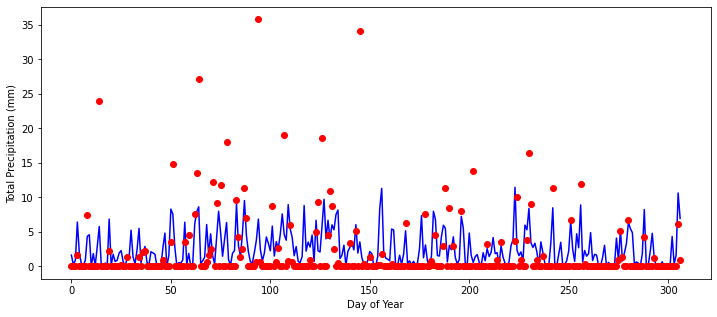

In [0]:
# Do the plot
fig, ax = plt.subplots(figsize = (12,5))
ax.plot(predictions, 'b-')
ax.plot(test_labels, 'ro')
ax.set_xlabel('Day of Year')
ax.set_ylabel('Total Precipitation (mm)')
plt.show()

In [0]:
# Get numerical feature importances
importances = list(rfprecip.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Avg 850hPa DWPDEP(C) Importance: 0.11
Variable: Min 850hPa DWPDEP(C) Importance: 0.09
Variable: Max 850hPa DWPDEP(C) Importance: 0.08
Variable: tmpc                 Importance: 0.07
Variable: skct                 Importance: 0.07
Variable: pr1h                 Importance: 0.07
Variable: Avg 925hPa DWPDEP(C) Importance: 0.07
Variable: Max 925hPa DWPDEP(C) Importance: 0.06
Variable: TMAX                 Importance: 0.05
Variable: WMAX                 Importance: 0.05
Variable: dwpc                 Importance: 0.05
Variable: mslp                 Importance: 0.05
Variable: Min 925hPa DWPDEP(C) Importance: 0.05
Variable: TMIN                 Importance: 0.04
Variable: RTOT                 Importance: 0.04
Variable: wdir                 Importance: 0.03
Variable: wspd                 Importance: 0.02
